In [1]:
import nltk
nltk.download('wordnet')
from nltk.corpus import gutenberg, stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as soup, SoupStrainer
import requests
import lxml
from collections import Counter
from requests import exceptions
import os
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from rake_nltk import Rake
import matplotlib.pyplot as plt; plt.rcdefaults()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import steam
from steam.api import interface
steam.api.key.set('FC864146AEF094845C669F86F0B20CFF')
pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_colwidth', 80)
%matplotlib inline

[nltk_data] Downloading package wordnet to /Users/sabol/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Steam Recommendation Engine #
## Overview ##
As someone somewhere probably said, it's the best time to be playing video games.  Democratization of the tools needed and technical know-how has gotten to the point that almost anyone can sit down and within a matter of 80-100 work weeks over 2-4 years (lol) crank out a game.  But with this over-abundance of choice comes a new problem... UNCERTAINTY. "Do I buy that hot new game that just came out?  What about that other new hot game that came out or that older game that everyone said was great?  Hell, maybe I should just play one of the games I already bought but never installed?”  My aim is to build a recommendation engine that will help people (ME) with this.  Specifically, the engine will not just recommend games available on steam, but will also recommend you games that are already in your library but unplayed.  Yay for saving money!

## Data Collection ##
In order to build the recommendation engine using steam, I used BeautifulSoup to crawl the Steam Store for all games with steam pages. I did this in two steps.  Step 1 was generating a list of links to each game's steam page, starting at page 1 (https://store.steampowered.com/search/?category1=998&page=1).  Once I was able to grab every link, I iterated through each one, grabbing relevant fields such as title, image, description, tags, reviews, etc.

### Grabbing each store link ###

In [ ]:
# Get title and links for all steam games
urls = ['https://store.steampowered.com/search/?category1=998&page={}'.format(i) for i in range(1, 1185)]

filename = "products_v2.csv"
f = open(filename, "w", encoding="utf-8")
headers = "game_title\tsteam_url\n"
f.write(headers)

for url in urls:
    r = requests.get(url)
    page_soup = soup(r.content, "html.parser")

    containers = page_soup.findAll("a", {"class":"search_result_row ds_collapse_flag "})

    for container in containers:
        game_title = container.findAll("span", {"class":"title"})[0].text
        link = container["href"]

        #print(game_title)
        #print(link)
        #print("----------------")

        f.write(game_title + "\t" + link + "\n")

f.close()

### Iterating through each link, grabing all relevant info from the page###

In [ ]:
df_links = pd.read_csv('products_v2.csv', delimiter="\t")

tags = []
images = []
descriptions = []
num_reviews = []
rating_values = []
releases = []

cookies = {'birthtime': '568022401'}

for link in df_links.iterrows():
    print(link[1]['game_title'])
    url = link[1]['steam_url']
    r = requests.get(url, cookies=cookies)
    page_soup = soup(r.content, 'lxml')
    try:
        tag = page_soup.find("div", {"class":"glance_tags popular_tags"})
        tag = tag.text
        tag = tag.replace('\t', '').replace('\r', '').replace('\n', ', ').replace('+, ', '').replace(', , ', '')
        tags.append(tag)
    except:
        tag = 'no tags'
        tags.append(tag)
    
    try:
        image = page_soup.find('img', {'class':'game_header_image_full'})['src']
        images.append(image)
    except:
        image = 'no_image'
        images.append(image)
    
    try:
        num_review = int(page_soup.find('meta', {'itemprop':'reviewCount'})['content'])
        num_reviews.append(num_review)
    except:
        num_review = 'no reviews'
        num_reviews.append(num_review)

    try:
        rating_value = float(page_soup.find('meta', {'itemprop':'ratingValue'})['content'])
        rating_values.append(rating_value)
    except:
        rating_value = 'no rating'
        rating_values.append(rating_value)
    
    try:
        description = page_soup.find('div', {'class': 'game_description_snippet'}).text.replace('\t','').replace('\r','').replace('\n', '')
        descriptions.append(description)
    except:
        description = 'no description'
        descriptions.append(description)
        
    try:
        release = page_soup.find('div', {'class': 'date'}).text
        releases.append(release)
    except:
        release = 'no release date'
        releases.append(release)

        
        
    
      
the_rest = pd.DataFrame({'tags': tags, 'image': images, 'description': descriptions,
                         'number_of_review': num_reviews,
                         'score': rating_values,
                         'release_date': releases})

steam_scrape_the_rest = pd.concat([df_links, the_rest], axis=1, sort=False)
steam_scrape_the_rest.to_csv('steam_games_all_fields.csv', sep='\t')

## Data Cleaning and Processing ##

In [2]:
steam_games = pd.read_csv('steam_games_all_fields.csv', index_col=0, delimiter='\t')

# Split out 'appid' from the URL string.  This will be used later to merge in my own games
# from the steam api
app_id = steam_games['steam_url'].str.split('/',expand=True)
app_id = app_id.drop([0, 1, 2, 5, 6], axis=1)
app_id.columns = ['app', 'game_ID']
df = pd.concat([steam_games, app_id], axis=1, sort=False)

# Fill nil values and remove random characters
df['description'] = df['description'].fillna('')
df = df[~df.description.str.contains('no description')]
df['release_date'] = df['release_date'].replace({'no release date' : ''})
df['game_title'] = df['game_title'].str.replace(r'®', '')
df['game_title'] = df['game_title'].str.replace(r'™', '')
df['number_of_review'] = df['number_of_review'].replace({'no reviews' : ''})
df['score'] = df['score'].replace({'no rating' : ''})

# Dropping unneeded/dupe columns and renaming others for merge purposes later
df = df.drop(['app'], axis=1)
df['game_ID'] = pd.to_numeric(df['game_ID'], downcast='signed')
df['number_of_review'] = pd.to_numeric(df['number_of_review'], downcast='integer')
df['score'] = pd.to_numeric(df['score'])

# Game must have a score, scores are not calculated until a min number of reviews is satisfied
df = df[df['score'] > 0]
df = df.rename(columns={"game_ID": "appid"})
df = df.rename(columns={"Unnamed: 0": "id"})
df = df.drop_duplicates(subset='appid', keep='first')
df = df.dropna(subset=['game_title'])
df = df.reset_index()
df = df.drop(['index'], axis=1)
print('Dataframe Shape', df.shape)
df.head()

Dataframe Shape (14596, 9)


,game_title,steam_url,tags,image,description,number_of_review,score,release_date,appid
0,Counter-Strike: Global Offensive,https://store.steampowered.com/app/730/CounterStrike_Global_Offensive/?snr=1...,"FPS, Multiplayer, Shooter, Action, Team-Based, Competitive, Tactical, First-...",https://steamcdn-a.akamaihd.net/steam/apps/730/header.jpg?t=1544148568,Counter-Strike: Global Offensive (CS: GO) expands upon the team-based action...,"2,915,091.00000",9.00000,"Aug 21, 2012",730
1,MONSTER HUNTER: WORLD,https://store.steampowered.com/app/582010/MONSTER_HUNTER_WORLD/?snr=1_7_7_23...,"Action, Hunting, Co-op, Open World, Multiplayer, Third Person, RPG, Adventur...",https://steamcdn-a.akamaihd.net/steam/apps/582010/header.jpg?t=1544082685,"Welcome to a new world! In Monster Hunter: World, the latest installment in ...","55,314.00000",6.00000,"Aug 9, 2018",582010
2,Path of Exile,https://store.steampowered.com/app/238960/Path_of_Exile/?snr=1_7_7_230_150_1,"Free to Play, Action RPG, Hack and Slash, RPG, Multiplayer, Massively Multip...",https://steamcdn-a.akamaihd.net/steam/apps/238960/header.jpg?t=1544390585,"You are an Exile, struggling to survive on the dark continent of Wraeclast, ...","74,977.00000",9.00000,"Oct 23, 2013",238960
3,Insurgency: Sandstorm,https://store.steampowered.com/app/581320/Insurgency_Sandstorm/?snr=1_7_7_23...,"FPS, Realistic, Shooter, Multiplayer, Action, Military, Tactical, Singleplay...",https://steamcdn-a.akamaihd.net/steam/apps/581320/header.jpg?t=1546538316,"Insurgency: Sandstorm is a team-based, tactical FPS based on lethal close qu...","9,019.00000",9.00000,"Dec 12, 2018",581320
4,Warframe,https://store.steampowered.com/app/230410/Warframe/?snr=1_7_7_230_150_1,"Free to Play, Action, Co-op, Multiplayer, Third-Person Shooter, Sci-fi, Ninj...",https://steamcdn-a.akamaihd.net/steam/apps/230410/header.jpg?t=1545251372,Warframe is a cooperative free-to-play third person online action game set i...,"236,593.00000",9.00000,"Mar 25, 2013",230410


In [3]:
df_desc = df[['number_of_review', 'score']]
df_desc.describe()

,number_of_review,score
count,"14,596.00000","14,596.00000"
mean,"1,709.28008",7.38113
std,"28,152.31748",1.38787
min,10.00000,2.00000
25%,25.00000,6.00000
50%,76.00000,7.00000
75%,345.00000,9.00000
max,"2,915,091.00000",10.00000


## Data Exploration ##

There are 3,098,835 words in the combination of all descriptions.


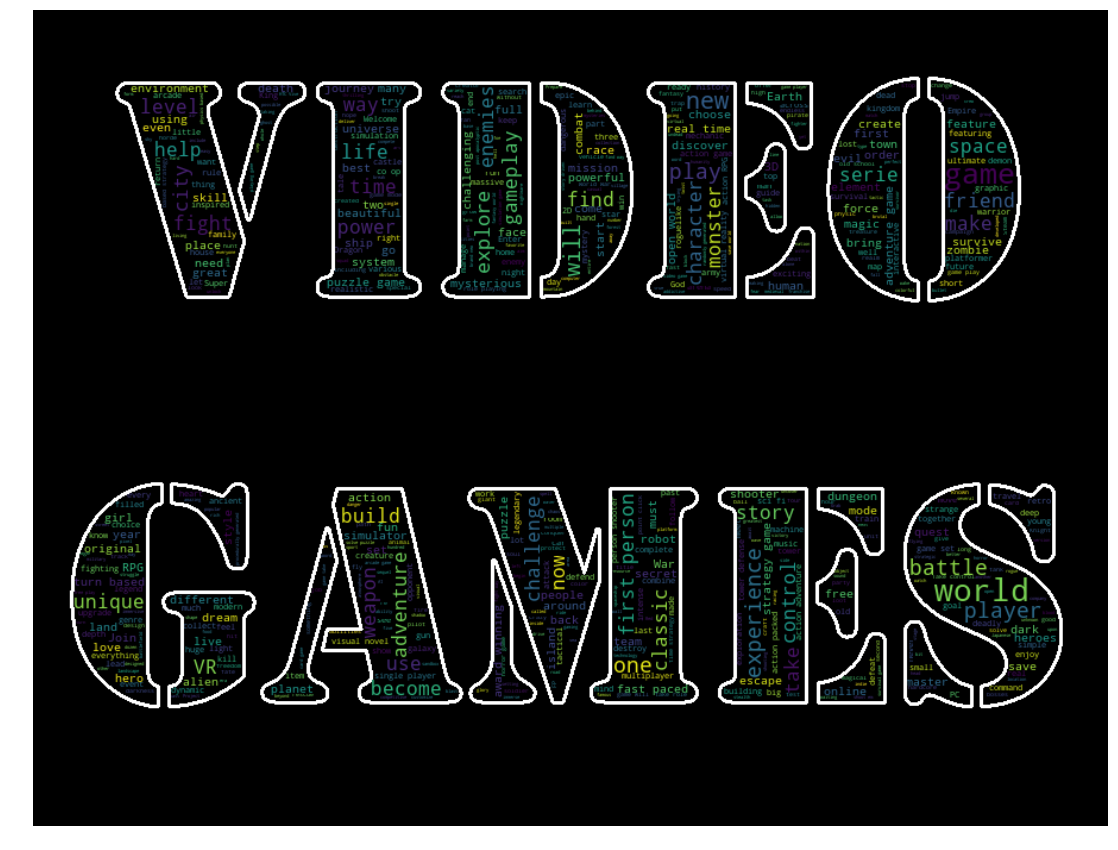

In [58]:
text = " ".join(desc for desc in df.description)
print ("There are {:,.0f} words in the combination of all descriptions.".format(len(text)))
stopwords = set(STOPWORDS)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
video_mask = np.array(Image.open(path.join(d, "video_game_mask.png")))
wc = WordCloud(stopwords=stopwords, background_color="black", max_words=10000,
                      contour_width=3, mask=video_mask, contour_color='white').generate(text)

wc.to_file(path.join(d, 'video_games.png'))

fig, ax = plt.subplots(figsize=(20, 15))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

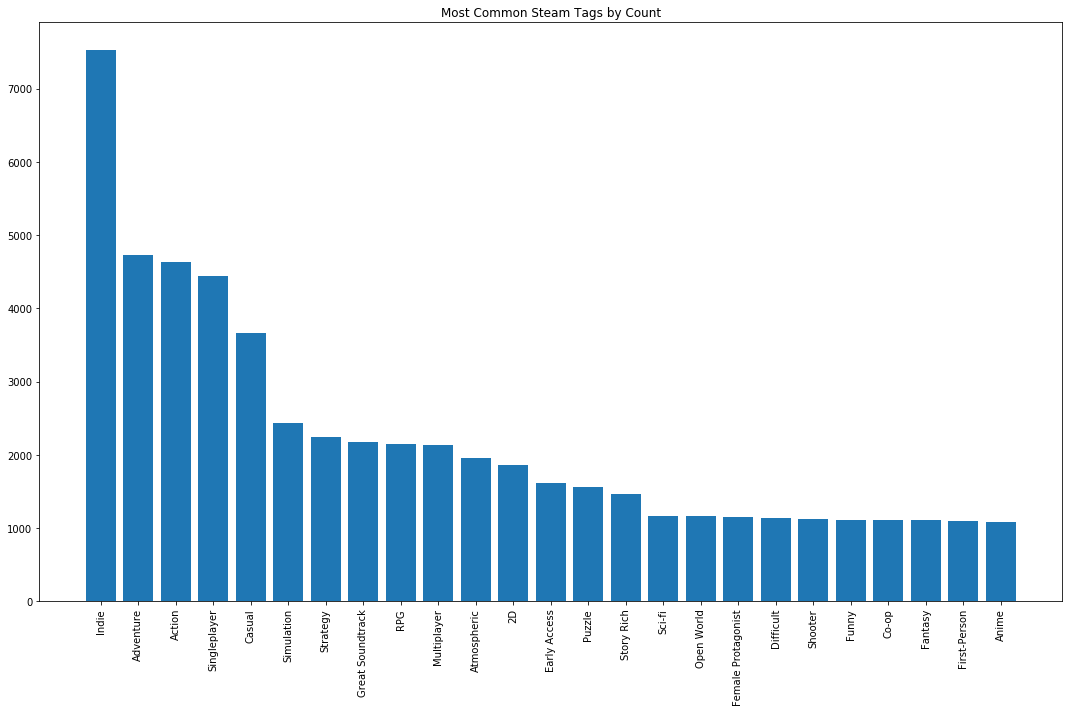

In [59]:
text = " ".join(desc for desc in df.tags)
textlist = text.split(", ")
wordfreq = [textlist.count(w) for w in textlist]
pairs = Counter(text.split(", ")).most_common(25)
word = []
frequency = []

for i in range(len(pairs)):
    word.append(pairs[i][0])
    frequency.append(pairs[i][1])

indices = np.arange(len(pairs))
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(indices, frequency)
plt.title('Most Common Steam Tags by Count', )
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

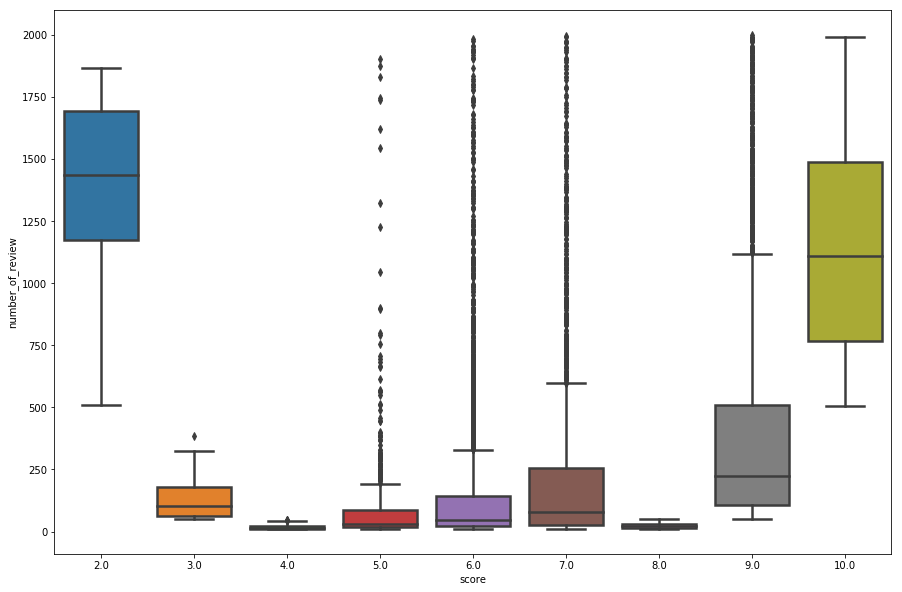

In [60]:
no_out = df[df['number_of_review'] < 2000]
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.boxplot(x="score", y = 'number_of_review', data=no_out, linewidth=2.5)

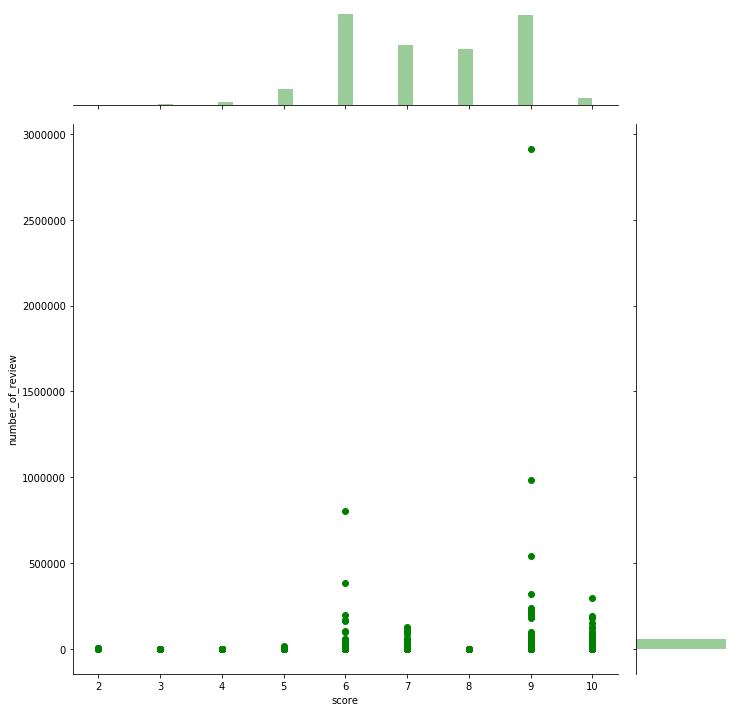

In [61]:

sns.jointplot(x='score', y='number_of_review', data=df, height=10, color='g')
#plt.title('Steam Tags by Count')
#plt.xticks(indices, word, rotation='vertical')
plt.show()

### Using the Steam API to Build My Games DF###
In order to create a recommendation engine that recommends my own games, I needed to find a way to procure my own steam games data.  While I could have also grabbed this data via web scraping, I decided to make use of Steam's API, which allows for easy access into a person's steam games library, provided a user_ID is provided.

In [15]:
my_steam_id = 76561197974553664
games = interface('IPlayerService').GetOwnedGames(steamid=my_steam_id, include_appinfo=1)
my_games = games['response']['games']
game_table = pd.DataFrame(my_games)
game_table = game_table.drop(['has_community_visible_stats', 'playtime_2weeks',
                              'img_icon_url', 'img_logo_url'], axis=1)
# Convert playtime from minutes to hours
game_table['playtime_forever'] = game_table['playtime_forever'] / 60
my_games_info = pd.merge(df, game_table, on='appid')
print('My Games DataFrame Shape:', my_games_info.shape)

my_games_describe = my_games_info[['number_of_review', 'score', 'playtime_forever']]
my_games_describe.describe()

My Games DataFrame Shape: (213, 11)


,number_of_review,score,playtime_forever
count,213.00000,213.00000,213.00000
mean,"39,327.68545",8.64319,9.38529
std,"208,823.54301",1.22644,20.50645
min,180.00000,5.00000,0.00000
25%,"3,998.00000",9.00000,0.01667
50%,"11,035.00000",9.00000,2.46667
75%,"23,045.00000",9.00000,10.01667
max,"2,915,091.00000",10.00000,188.78333


In [16]:
# Create DF of all the steam games that I don't own
not_my_games = pd.merge(df, game_table, how='outer', on='appid')
not_my_games = not_my_games[not_my_games['playtime_forever'].isnull()]
not_my_games = not_my_games.drop(['name', 'image', 'playtime_forever'], axis=1)
print('Dataframe Shape:', not_my_games.shape)

Dataframe Shape: (14383, 8)


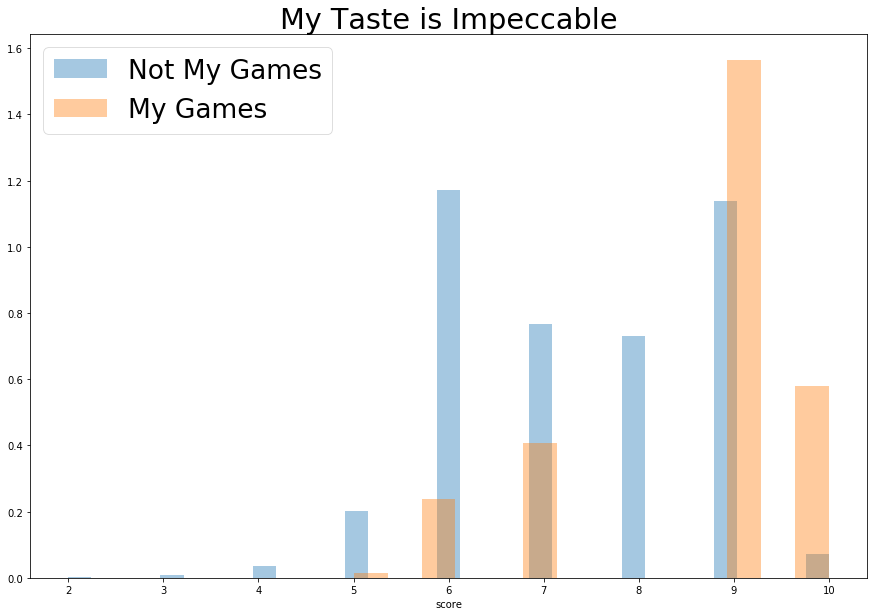

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_context("paper", font_scale=3)
sns.distplot(not_my_games['score'], norm_hist=True, kde=False, label='Not My Games', ax=ax)
sns.distplot(my_games_info['score'], norm_hist=True, kde=False, label='My Games', ax=ax)
plt.title('My Taste is Impeccable')
plt.legend()
plt.show()

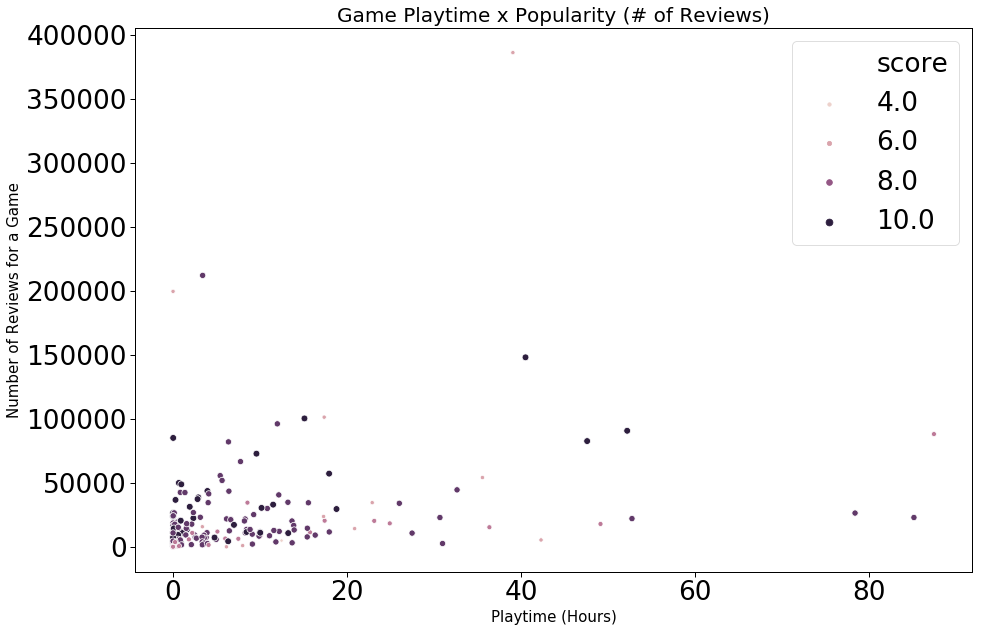

In [65]:
# Removed outliers.  'Counter-Strike' is a free-to-play game with > 2 million reviews
df_csno = my_games_info[~my_games_info.game_title.str.contains('Counter-Strike: Global Offensive')]
df_csno = df_csno[df_csno['playtime_forever'] <= 100]

fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.scatterplot(x="playtime_forever", y="number_of_review", hue="score", 
                     size= 'score', data=df_csno)
plt.title('Game Playtime x Popularity (# of Reviews)', size = 20)
plt.xlabel('Playtime (Hours)', size=15)
plt.ylabel('Number of Reviews for a Game', size=15)
plt.show()

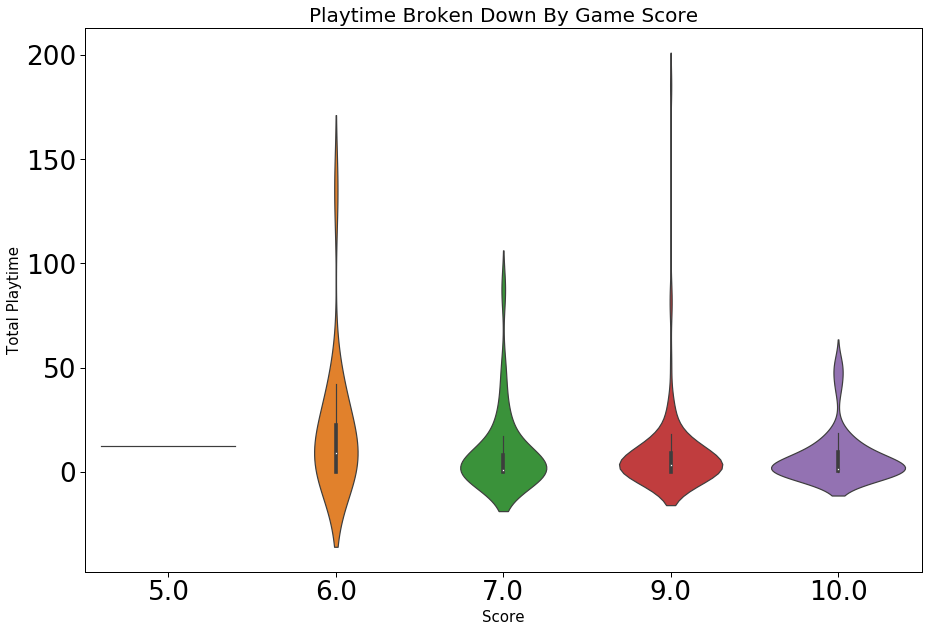

In [66]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(x="score", y="playtime_forever", data=my_games_info)
plt.title('Playtime Broken Down By Game Score', size = 20)
plt.xlabel('Score', size=15)
plt.ylabel('Total Playtime', size=15)
plt.show()

## Building the Recommender ##

Evaluating a recommender is tough.  Since people's choices and preferences are subjective, there aren't a lot of metrics that can tell you whether or not your enginge performed well beyond looking at it and thinking that it did a goog job.  To try and combat this a bit, I built 3 different versions of the engine, one run by steam tags, another by descriptions, and a hybrid of the two. Then within each of those groups I split out the engine to have 1 that selects games you already own and recommends them to you, and another that looks at all the games you don't own.
<br>

For building the actual recommender system, I had originally decided that I would use Steam tags that are associated with every game.  However, because it was easy enough to collect, I also had descriptions for every game.  So I decided to test the recommendation system with three different setups.  The first being description only, the second being tags only, and the third being a hybrid of both.

### How the Recommender Works ###
While I will have built a number of different version, all of the recommenders work in roughly the same way.  Text (either game descriptions or steam tags) is taken in and converted into a matrix of token counts via sklearn's CountVectorizer module.  

### Parsing Game Descriptions ###
For building the recommender with text descriptions, I had initially wanted to use sklearn's term frequency inverse document frequency module to break the descriptions down to components and assign specific weights to words, but over the course of testing I found that the countvectorizer module produced much better results across all of the models I built. TFIDF was matching up games with very short descriptions that had I uncommon word in them but nothing else.  Countvectorizer got rid of this problem.

In [5]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [6]:
cv_desc = df[['appid', 'game_title', 'tags', 'description']]

stop_words = set(STOPWORDS)
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

cv_desc['stemmed'] = cv_desc.description.apply(lambda x: stemmer.stem(x))
cv_desc['tokens'] = cv_desc.stemmed.apply(lambda x: tokenizer.tokenize(x))
cv_desc['lemmed'] = cv_desc.tokens.apply(lemmatize_text)
cv_desc['stopped'] = cv_desc.lemmed.apply(lambda x: [item for item in x if item not in stop_words])
cv_desc['desc']=cv_desc['stopped'].apply(lambda x: ', '.join(map(str, x)))

In [39]:
cv_desc['desc'][3]

'insurgency, sandstorm, team, based, tactical, fps, based, lethal, close, quarter, combat, objective, oriented, multiplayer, gameplay, experience, intensity, modern, combat, skill, rewarded, teamwork, win, fight'

After stemming, tokening, lemming, and stopping the description data, I ran it through the Countvectorizer.  I set ngram_range equal to (1, 2) since often games have titles that are multiple words long and I wanted those values to be extracted together.  Once I got the matrix of counts I applyed the cosine_similarity function in order to compute the similarity of each game.

In [69]:
cv = CountVectorizer(analyzer='word', lowercase=True, ngram_range=(1,2))
cv_matrix = cv.fit_transform(cv_desc['desc'])

# Linear kernel provides better results for descriptions
cosine_similarities = cosine_similarity(cv_matrix, cv_matrix)

results_desc = {}

for idx, row in cv_desc.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-500:-1]
    similar_items = [(cosine_similarities[idx][i], cv_desc['appid'][i]) for i in similar_indices]
    results_desc[row['appid']] = similar_items[1:]
    
print('Done!')

Done!


In [12]:
def recommend(game, num):
    app_id = cv_desc.loc[cv_desc['game_title'] == game]['appid'].tolist()[0]
    
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          game + '.')

    rez = results_desc[app_id]

    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, my_games_info, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'name', 'score',
                                  'tags', 'description', 'steam_url', 'image'], axis = 1)
   
    # Filter out games I've played more than an hour of
    my_game_df = my_game_df[my_game_df['playtime_forever'] <= 1]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 5)

Recommending 5 games sitting in your Steam library unplayed, that are similar to Assassin's Creed Odyssey.


NameError: name 'results_desc' is not defined

In [11]:
def recommend(game, num):
    app_id = cv_desc.loc[cv_desc['game_title'] == game]['appid'].tolist()[0]
    
    print('Fine, here are ' + str(num) + " games you could buy that are similar to " + 
          game + '.')

    rez = results_desc[app_id]
   
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    
    my_game_df = pd.merge(sim_score_df, not_my_games, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'score',
                                  'tags', 'description'], axis = 1)
    #my_game_df = my_game_df[my_game_df['playtime_forever'] <= 60]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 5)

Fine, here are 5 games you could buy that are similar to Assassin's Creed Odyssey.


NameError: name 'results_desc' is not defined

#### Using Steam Tags to Build the Engine ####
Every game on steam has a set of user-defined tags that it gets associated to.  Here, I used these tags to compute the similarity betwe

In [8]:
count_vec_tags = df[['appid', 'game_title', 'tags', 'description']]
vectorizer = CountVectorizer(analyzer='word', lowercase=True, ngram_range=(1,2))
count_matrix = vectorizer.fit_transform(count_vec_tags['tags'])
cosine_similarities = cosine_similarity(count_matrix, count_matrix)
results_tags = {}

for idx, row in count_vec_tags.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-500:-1]
    similar_items = [(cosine_similarities[idx][i], count_vec_tags['appid'][i]) for i in similar_indices]

    # First item is the item itself, so remove it.
    # Each dictionary entry is like: [(1,2), (3,4)], with each tuple being (score, item_id)
    results_tags[row['appid']] = similar_items[1:]
    
print('Done!')

Done!


In [41]:
vectorizer = CountVectorizer(analyzer='word', lowercase=True, ngram_range=(1,2))
count_matrix = vectorizer.fit_transform(count_vec_tags['tags'])
count_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [28]:
count_vec_tags[['game_title','tags']]

,game_title,tags
0,Counter-Strike: Global Offensive,"FPS, Multiplayer, Shooter, Action, Team-Based, Competitive, Tactical, First-..."
1,MONSTER HUNTER: WORLD,"Action, Hunting, Co-op, Open World, Multiplayer, Third Person, RPG, Adventur..."
2,Path of Exile,"Free to Play, Action RPG, Hack and Slash, RPG, Multiplayer, Massively Multip..."
3,Insurgency: Sandstorm,"FPS, Realistic, Shooter, Multiplayer, Action, Military, Tactical, Singleplay..."
4,Warframe,"Free to Play, Action, Co-op, Multiplayer, Third-Person Shooter, Sci-fi, Ninj..."
5,Divinity: Original Sin 2 - Definitive Edition,"RPG, Turn-Based, Co-op, Story Rich, Fantasy, Open World, Character Customiza..."
6,Assassin's Creed Odyssey,"Open World, Action, RPG, Singleplayer, Adventure, Assassin, Historical, Stea..."
7,Rocket League,"Multiplayer, Racing, Soccer, Sports, Competitive, Team-Based, Online Co-Op, ..."
8,Tom Clancy's Rainbow Six Siege,"FPS, Multiplayer, Tactical, Shooter, Action, Team-Based, First-Person, Co-op..."
9,Grand Theft Auto V,"Open World, Action, Multiplayer, Third Person, First-Person, Crime, Shooter,..."


In [23]:
def recommend(game, num):
    app_id = count_vec_tags.loc[count_vec_tags['game_title'] == game]['appid'].tolist()[0]
    
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          game + '.')

    rez = results_tags[app_id]
    #print(rez)
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    #print(df_test)
    my_game_df = pd.merge(sim_score_df, my_games_info, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'name', 'score',
                                  'tags', 'description', 'steam_url', 'image'], axis = 1)
    my_game_df = my_game_df[my_game_df['playtime_forever'] <= 1]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("DARK SOULS III", 5)

Recommending 5 games sitting in your Steam library unplayed, that are similar to DARK SOULS III.


,sim_score,game_title,playtime_forever
3,0.47692,Fallout 3: Game of the Year Edition,0.00000
7,0.44467,Fallout: New Vegas,0.66667
16,0.40469,Mass Effect 2,0.58333
25,0.38742,Prince of Persia,0.00000
30,0.36795,Darksiders Warmastered Edition,0.00000


In [24]:
def recommend(game, num):
    app_id = count_vec_tags.loc[count_vec_tags['game_title'] == game]['appid'].tolist()[0]
    
    print('Fine, here are ' + str(num) + " games you could buy that are similar to " + 
          game + '.')

    rez = results_tags[app_id]
    #print(rez)
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    #print(df_test)
    my_game_df = pd.merge(sim_score_df, not_my_games, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'score',
                                  'tags', 'description'], axis = 1)
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("DARK SOULS III", 10)

Fine, here are 10 games you could buy that are similar to DARK SOULS III.


,sim_score,game_title,steam_url
0,0.71220,DARK SOULS: REMASTERED,https://store.steampowered.com/app/570940/DARK_SOULS_REMASTERED/?snr=1_7_7_2...
1,0.61538,DARK SOULS: Prepare To Die Edition,https://store.steampowered.com/app/211420/DARK_SOULS_Prepare_To_Die_Edition/...
2,0.58462,DARK SOULS II: Scholar of the First Sin,https://store.steampowered.com/app/335300/DARK_SOULS_II_Scholar_of_the_First...
3,0.58133,Risen,https://store.steampowered.com/app/40300/Risen/?snr=1_7_7_230_150_95
4,0.55385,Two Worlds II HD,https://store.steampowered.com/app/7520/Two_Worlds_II_HD/?snr=1_7_7_230_150_222
5,0.54903,Gothic II: Gold Edition,https://store.steampowered.com/app/39510/Gothic_II_Gold_Edition/?snr=1_7_7_2...
6,0.54854,Two Worlds Epic Edition,https://store.steampowered.com/app/1930/Two_Worlds_Epic_Edition/?snr=1_7_7_2...
7,0.54694,The Elder Scrolls IV: Oblivion Game of the Year Edition,https://store.steampowered.com/app/22330/The_Elder_Scrolls_IV_Oblivion_Game_...
8,0.54694,Dragon's Dogma: Dark Arisen,https://store.steampowered.com/app/367500/Dragons_Dogma_Dark_Arisen/?snr=1_7...
9,0.53158,Risen 2: Dark Waters,https://store.steampowered.com/app/40390/Risen_2_Dark_Waters/?snr=1_7_7_230_...


#### Hybrid Descriptions & Steam Tags ####
Now let's mash the two together and see what we get.

In [75]:
cv_hybrid = df[['appid', 'game_title', 'tags', 'description']]

stop_words = set(STOPWORDS)
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

cv_hybrid['stemmed'] = cv_hybrid.description.apply(lambda x: stemmer.stem(x))
cv_hybrid['tokens'] = cv_hybrid.stemmed.apply(lambda x: tokenizer.tokenize(x))
cv_hybrid['lemmed'] = cv_hybrid.tokens.apply(lemmatize_text)
cv_hybrid['stopped'] = cv_hybrid.lemmed.apply(lambda x: [item for item in x if item not in stop_words])
cv_hybrid['desc']=cv_hybrid['stopped'].apply(lambda x: ', '.join(map(str, x)))


In [76]:
cv_hybrid['tag_desc'] = cv_hybrid[['tags', 'desc']].apply(lambda x: ' '.join(x), axis=1)
cv = CountVectorizer(analyzer='word', lowercase=True, ngram_range=(1,2))
cv_hybrid_matrix = cv.fit_transform(cv_hybrid['tag_desc'])
cosine_similarities = cosine_similarity(cv_hybrid_matrix, cv_hybrid_matrix)

results_tags_desc = {}

for idx, row in cv_hybrid.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-500:-1]
    similar_items = [(cosine_similarities[idx][i], cv_hybrid['appid'][i]) for i in similar_indices]

    # First item is the item itself, so remove it.
    # Each dictionary entry is like: [(1,2), (3,4)], with each tuple being (score, item_id)
    results_tags_desc[row['appid']] = similar_items[1:]
    
print('done!')


done!


In [77]:
def recommend(game, num):
    app_id = cv_hybrid.loc[cv_hybrid['game_title'] == game]['appid'].tolist()[0]
    
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          game + '.')

    rez = results_tags_desc[app_id]
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, my_games_info, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'name', 'score',
                                  'tags', 'description', 'steam_url', 'image'], axis = 1)
    my_game_df = my_game_df[my_game_df['playtime_forever'] <= 1]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 5)

Recommending 5 games sitting in your Steam library unplayed, that are similar to Assassin's Creed Odyssey.


,sim_score,game_title,playtime_forever
12,0.23034,Mass Effect 2,0.58333
19,0.21553,Fallout: New Vegas,0.66667
22,0.21332,Prince of Persia,0.00000
24,0.21096,Quantum Break,0.00000
26,0.20739,Fallout 3: Game of the Year Edition,0.00000


In [78]:
def recommend(game, num):
    app_id = cv_hybrid.loc[cv_hybrid['game_title'] == game]['appid'].tolist()[0]
    
    print('Fine, here are ' + str(num) + " games you could buy that are similar to " + 
          game + '.')

    rez = results_tags_desc[app_id]
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, not_my_games, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'score',
                                  'tags', 'description'], axis = 1)
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 5)

Fine, here are 5 games you could buy that are similar to Assassin's Creed Odyssey.


,sim_score,game_title,steam_url
0,0.34221,Assassin's Creed Origins,https://store.steampowered.com/app/582160/Assassins_Creed_Origins/?snr=1_7_7...
1,0.32938,Assassin’s Creed Brotherhood,https://store.steampowered.com/app/48190/Assassins_Creed_Brotherhood/?snr=1_...
2,0.31906,Assassin's Creed Revelations,https://store.steampowered.com/app/201870/Assassins_Creed_Revelations/?snr=1...
3,0.31555,Assassin's Creed Freedom Cry,https://store.steampowered.com/app/277590/Assassins_Creed_Freedom_Cry/?snr=1...
4,0.31500,Assassin's Creed Syndicate,https://store.steampowered.com/app/368500/Assassins_Creed_Syndicate/?snr=1_7...


Hybrid certainly looks good.  Let's test it out on some others just to see.

In [79]:
def recommend(game, num):
    app_id = cv_hybrid.loc[cv_hybrid['game_title'] == game]['appid'].tolist()[0]
    
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          game + '.')

    rez = results_tags_desc[app_id]
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, my_games_info, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'name', 'score',
                                  'tags', 'description', 'steam_url', 'image'], axis = 1)
    my_game_df = my_game_df[my_game_df['playtime_forever'] <= 1]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Rocket League", 10)

Recommending 10 games sitting in your Steam library unplayed, that are similar to Rocket League.


,sim_score,game_title,playtime_forever
0,0.43552,Trine 2: Complete Story,0.00000
1,0.41902,Monaco: What's Yours Is Mine,0.00000
2,0.41270,Trine Enchanted Edition,0.00000
3,0.38521,Lethal League,0.00000
5,0.37952,Awesomenauts - the 2D moba,0.01667
6,0.36714,Mount Your Friends,0.23333
7,0.36706,Castle Crashers,0.28333
13,0.31260,Lara Croft and the Guardian of Light,0.00000
20,0.27832,Guacamelee! Gold Edition,0.00000
25,0.25652,Octodad: Dadliest Catch,0.83333


In [80]:
def recommend(game, num):
    app_id = cv_hybrid.loc[cv_hybrid['game_title'] == game]['appid'].tolist()[0]
    
    print('Fine, here are ' + str(num) + " games you could buy that are similar to " + 
          game + '.')

    rez = results_tags_desc[app_id]
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, not_my_games, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'score',
                                  'tags', 'description'], axis = 1)
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Rocket League", 10)

Fine, here are 10 games you could buy that are similar to Rocket League.


,sim_score,game_title,steam_url
0,0.47204,Move or Die,https://store.steampowered.com/app/323850/Move_or_Die/?snr=1_7_7_230_150_16
1,0.47031,Stick Fight: The Game,https://store.steampowered.com/app/674940/Stick_Fight_The_Game/?snr=1_7_7_23...
2,0.46111,Bloody Trapland,https://store.steampowered.com/app/257750/Bloody_Trapland/?snr=1_7_7_230_150_74
3,0.45294,Sonic & All-Stars Racing Transformed Collection,https://store.steampowered.com/app/212480/Sonic__AllStars_Racing_Transformed...
4,0.44901,Robot Roller-Derby Disco Dodgeball,https://store.steampowered.com/app/270450/Robot_RollerDerby_Disco_Dodgeball/...
5,0.44169,Hacktag,https://store.steampowered.com/app/622770/Hacktag/?snr=1_7_7_230_150_181
6,0.44113,Overcooked,https://store.steampowered.com/app/448510/Overcooked/?snr=1_7_7_230_150_14
7,0.43618,Overcooked! 2,https://store.steampowered.com/app/728880/Overcooked_2/?snr=1_7_7_230_150_2
8,0.42864,ROCKETSROCKETSROCKETS,https://store.steampowered.com/app/289760/ROCKETSROCKETSROCKETS/?snr=1_7_7_2...
9,0.42447,BattleBlock Theater,https://store.steampowered.com/app/238460/BattleBlock_Theater/?snr=1_7_7_230...


In [81]:
def recommend(game, num):
    app_id = cv_hybrid.loc[cv_hybrid['game_title'] == game]['appid'].tolist()[0]
    
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          game + '.')

    rez = results_tags_desc[app_id]
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, my_games_info, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'name', 'score',
                                  'tags', 'description', 'steam_url', 'image'], axis = 1)
    my_game_df = my_game_df[my_game_df['playtime_forever'] <= 1]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("PLAYERUNKNOWN'S BATTLEGROUNDS", 10)

Recommending 10 games sitting in your Steam library unplayed, that are similar to PLAYERUNKNOWN'S BATTLEGROUNDS.


,sim_score,game_title,playtime_forever
0,0.46357,H1Z1,0.00000
4,0.36225,Lead and Gold: Gangs of the Wild West,0.68333
7,0.35001,"Star Wars: Battlefront 2 (Classic, 2005)",0.13333
9,0.33959,"Warhammer 40,000: Space Marine",0.30000
16,0.32108,Red Faction: Armageddon,0.00000
25,0.28841,Red Orchestra 2: Heroes of Stalingrad with Rising Storm,0.20000
26,0.28370,Day of Defeat: Source,0.15000
28,0.27832,Lara Croft and the Guardian of Light,0.00000
35,0.24291,Alan Wake's American Nightmare,0.00000
36,0.24249,Trine 2: Complete Story,0.00000


In [82]:
def recommend(game, num):
    app_id = cv_hybrid.loc[cv_hybrid['game_title'] == game]['appid'].tolist()[0]
    
    print('Fine, here are ' + str(num) + " games you could buy that are similar to " + 
          game + '.')

    rez = results_tags_desc[app_id]
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, not_my_games, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'score',
                                  'tags', 'description'], axis = 1)
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("PLAYERUNKNOWN'S BATTLEGROUNDS", 10)

Fine, here are 10 games you could buy that are similar to PLAYERUNKNOWN'S BATTLEGROUNDS.


,sim_score,game_title,steam_url
0,0.54247,Pixel Royale,https://store.steampowered.com/app/931250/Pixel_Royale/?snr=1_7_7_230_150_934
1,0.54149,Realm Royale,https://store.steampowered.com/app/813820/Realm_Royale/?snr=1_7_7_230_150_31
2,0.50219,Ring of Elysium,https://store.steampowered.com/app/755790/Ring_of_Elysium/?snr=1_7_7_230_150_9
3,0.49696,Freefall Tournament,https://store.steampowered.com/app/849940/Freefall_Tournament/?snr=1_7_7_230...
4,0.47289,Infected Battlegrounds,https://store.steampowered.com/app/843730/Infected_Battlegrounds/?snr=1_7_7_...
5,0.46973,ORION: Prelude,https://store.steampowered.com/app/104900/ORION_Prelude/?snr=1_7_7_230_150_204
6,0.46847,Primal Carnage: Extinction,https://store.steampowered.com/app/321360/Primal_Carnage_Extinction/?snr=1_7...
7,0.46064,Holdfast: Nations At War,https://store.steampowered.com/app/589290/Holdfast_Nations_At_War/?snr=1_7_7...
8,0.45648,Until None Remain: Battle Royale PC Edition,https://store.steampowered.com/app/697010/Until_None_Remain_Battle_Royale_PC...
9,0.44967,Until None Remain: Battle Royale VR,https://store.steampowered.com/app/697020/Until_None_Remain_Battle_Royale_VR...


### I Declare Hybrid The Winner ###
While all three of the models performed well and gave me results that I would consider well within the normal range of what I might consider to be a good recommendation, I think the hybrid system does slightly better than the tag-only system, so it gets the edge.  The fact that it was able to see that I fed it an Assassin's Creed game and recommend me literally EVERY single one that I don't own (on steam) is commendable.  It also performed well when I fed it a party/competative game (Rocket League) and a large scale shooter (PlayerUnknown's Battlegrounds). 

<br>
The tag-only system also did well and, one could, say that it is actually a better performer cause it give some variety, but I don't want variety I want games that I'm going to like!  Description-only comes in last, not surprising considering that most game descriptions on the steam store can be fairly generic and short.

### Evaluation ###
While evalulation a content-based filtering system is tough due to the subjective nature of recommendations, we can do a little bit to prove that the recommender is basic than something more basic.
<br>

Below I wrote out two different simple models that output a list of games at random, for both the games in my steam list and also any and all games in the steam store.  In the second group, I sorted the order by a metric I made up called "popularity", which is simply the score a game has multiplied by it's number of reviews.  Let's see how they did.

In [83]:
rando_games = df.iloc[np.random.choice(np.arange(len(df)), 10, False)]
print('Random List of Steam Games', '\n')
print(rando_games[['game_title', 'score']].head())
print('------------------------------------------------------------------------------')
my_games_rando = my_games_info[my_games_info['playtime_forever'] <= 1]
my_games_rando = my_games_rando.iloc[np.random.choice(np.arange(len(my_games_rando)), 10, False)]
print('Random List of My Games:')
print(my_games_rando[['game_title', 'score']].head())

Random List of Steam Games 

                               game_title   score
2661                   Forward to the Sky 9.00000
3237                            Paperbark 8.00000
4546   Precipice of Darkness, Episode Two 9.00000
10149       Truck Mechanic Simulator 2015 6.00000
2341     Serious Sam Classics: Revolution 9.00000
------------------------------------------------------------------------------
Random List of My Games:
                                                  game_title    score
102                                            Quantum Break  9.00000
154  Red Orchestra 2: Heroes of Stalingrad with Rising Storm  9.00000
122                                              Antichamber 10.00000
196                                       TrackMania² Canyon  7.00000
76                                               Half-Life 2 10.00000


In [84]:
df['popularity'] = df['score'] * df['number_of_review']
rando_games = df.iloc[np.random.choice(np.arange(len(df)), 10, False)]
rando_games = rando_games.sort_values(['popularity'], ascending=False)
print('Random List of Steam Games Sorted By Popularity:')
print(rando_games[['game_title', 'popularity']].head(), '\n')
print('------------------------------------------------------------------------------')
my_games_info['popularity'] = my_games_info['score'] * my_games_info['number_of_review']
my_games_rando = my_games_info[my_games_info['playtime_forever'] <= 1]
my_games_rando = my_games_rando.iloc[np.random.choice(np.arange(len(my_games_rando)), 10, False)]
my_games_rando = my_games_rando.sort_values(['popularity'], ascending=False)
print('Random List of Games I Own Sorted By Popularity:')
print(my_games_rando[['game_title', 'popularity']].head())

Random List of Steam Games Sorted By Popularity:
                         game_title    popularity
254                Prison Architect 245,655.00000
471   Grand Theft Auto: San Andreas 215,163.00000
7088         SCP: Secret Laboratory 167,643.00000
5721         Alien Rage - Unlimited   5,131.00000
4560               Worms Crazy Golf   1,863.00000 

------------------------------------------------------------------------------
Random List of Games I Own Sorted By Popularity:
                  game_title   popularity
102            Quantum Break 74,322.00000
200  Half-Life 2: Lost Coast 41,679.00000
143                    Braid 38,502.00000
165              The Swapper 36,340.00000
212              Dear Esther 26,964.00000


As expected, the completely random one doesn't fair too well.  Since there are > 14k steam games, there's is a lot of variabiilty in the types of games you're going to get each time you run it.  Also, since it's strictly random, it does not take into account any preference you might have.  The ordered by popularity random list fairs slightly better in that, at least you're getting fed games of a, generally, high quality.  However, as before, this model does not care about your preferences, if you are looking to play a shooting game, this model is just as likely to recommend you a narrative text adventure as it would a shooter (or anything else).

## Running in Production + Conclusions ##
To run this fully in production I would make a couple changes.  For starters I would not include the scraping utility in the callable program since it takes longer to run than any reasonable person would want to wait.  Ideally that would be something that gets run once a week, with an updated version of the dataset replacing the old, so that whenver the program is run it's fetching the newest data.  I would also not have 3 different versions of this program, only the hybrid would remain since it produced the best results.  For a user to run the program, a web-based UI would probably work best. It would need two inputs in order to run, the steam_id of the person, as well as a game they want to use to seed the recommender.  A v2 implementation would have an option to auto-seed based on the user's most played game, but we're still on v1 right now...
<br>

Overall I would say that I'm fairly pleased with the results I was able to get.  My original vision for this project was to be able to create a program that would recommend me a game that I already owned but hadn't played, which I have succeeded in doing.  Areas of improvement though would be around dataset size as well as automatically inputting whatever your most played game is (or group of games).  While Steam is the largest gaming platform on PC, there are many other platforms with big games that were left out of this dataset. Either scraping those sites and incorporating them into the overall dataset, or finding and utilizing a 3rd party database API would result in a bigger set of data and better recommendations.